<h1>2. Vector Auto Regression (VAR) & Vector Error Correction Models (VECM)</h1> 
<hr>
<h2>Overview</h2>
Following on from the ARIMA notebook, this is an example application of the Vector Autorregression (VAR) model and Vector Error Correction (VECM) model. In principal, VAR is very similar to AR, except that rather than being univariate, it is multivariate. VECM is also methodolically related but is capable of working with non-stationary data.<br><br> Not to be confused with multiple regression, both examples are multivariate models, meaning that multiple variables are being modelled at once, and each variable's past values are thought to contribute to all variables present values. 
<br>
The data used is immaterial to the purpose of the notebook, but for clarity's sake the *macrodata* dataset from the statsmodels package is used. The dependent variable used for all models is realgdp. The independent variables are realdpi (disposable income) & cpi (consumer price inflation).<br><br>
Contents:<br>
2.0) Explore Data & Ensure Stationarity<br>
2.1) Vector Autoregression (VAR)<br>
2.2) Vector Error Correction Model (VECM)<br>
2.3) Model Evaluation<br>
<h2>2.0) Explore Data & Ensure Stationarity</h2>

<AxesSubplot:>

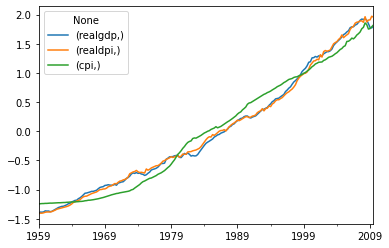

In [241]:
import pandas as pd
import statsmodels.api as sm
from scipy import stats 
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import select_order
import statsmodels.tsa.vector_ar.vecm as vecm 
from statsmodels.tsa.api import VAR
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error

df = sm.datasets.macrodata.load_pandas().data
df['month'] = df['quarter'].apply(lambda x: 3 * x)
df['date_str'] = df['year'].astype(int).astype(str) + '-' + df['month'].astype(int).astype(str).str.zfill(2) + '-01'
df['date'] = pd.to_datetime(df['date_str'])

start_date = df['date'].iloc[0]
end_date = df['date'].iloc[-1] + timedelta(days=30)
index = pd.date_range(start=start_date, end=end_date, freq='Q')

df = df[['realgdp', 'realdpi', 'cpi']]
df.index = index

# Standardise columns to account for differences in unit scale
data = pd.DataFrame(stats.zscore(df), columns=[cols], index=df.index)

data.plot()

After standardising the variables to account for differences in unit size, it is clear from a simple visual examination that they are collinear with an obvious upward trend (i.e. not stationary). VAR models presuppose that variables are stationary and so some differencing will need to be applied in pursuit of stationarity. 

<AxesSubplot:>

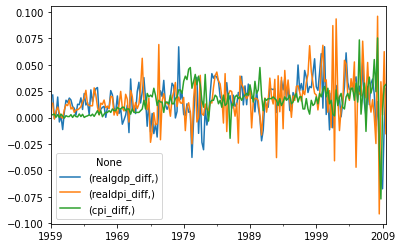

In [242]:
data[['realgdp_diff', 'realdpi_diff', 'cpi_diff']] = data[cols].diff(1)
data[['realgdp_diff', 'realdpi_diff', 'cpi_diff']].plot()

Visually, after differencing, there seems to be a more consistent mean for all variables. The variance is not obviously constant, but some ADF tests can be used to determine stationarity using a more mathematically robust methodology. For the purposes of this example, I will use alpha=0.1 (90% conf. interval), although alpha=0.05 is more typically used. 

In [243]:
def adf_test(series):
    adf_result = adfuller(series)
    print(series.name)
    print('p-value: %6f' % adf_result[1])
        
diff_data = data[['realgdp_diff', 'realdpi_diff', 'cpi_diff']].dropna() # redeine data to only include diff
diff_data.apply(adf_test)

('realgdp_diff',)
p-value: 0.000000
('realdpi_diff',)
p-value: 0.000000
('cpi_diff',)
p-value: 0.058919


realgdp_diff    None
realdpi_diff    None
cpi_diff        None
dtype: object

Each of the p-values are less than the chosen alpha (0.1), so for our purposes the data (after being differenced once) can be considred stationary with 90% confidence. The final step of preprocessing is to split into training and test data, which will be done at a ratio of 80-20. 

In [244]:
def create_train_test_dfs(df, train_pct):
    split_idx = round(train_pct * len(df))
    train = df[:split_idx]
    test = df[split_idx:]
    return train, test

train, test = create_train_test_dfs(diff_data, 0.8)

<h2>2.1) Vector Auto Regression (VAR)</h2>
A more sophisticated version of the Auto Regressive (AR) model, VAR predicts the value of a variable using past values. There is only one tunable paramater for VAR, similar to AR, which is p. p represents the number of lags incorporated into the model. The key difference between AR and VAR is that due to its use of vectors, VAR can incorporate more than one variable, allowing for the modelling of interactions between variables and the acknoweldgement that a variable's current value may be influence by variables other than itself. 
Written in matrix notation, the formula for VAR is:
$$Y = \beta X + U$$
Where at a given time, Y is a vector of the dependent variables, X is a vector of independent variables, and U is a vector of errors. <br><br>Using more detailed notation, lets sat that we are predicting a 2x1 vector at time t:<br>
$${\displaystyle {\begin{bmatrix}y_{1,t}\\y_{2,t}\end{bmatrix}}={\begin{bmatrix}c_{1}\\c_{2}\end{bmatrix}}+{\begin{bmatrix}a_{1,1}&a_{1,2}\\a_{2,1}&a_{2,2}\end{bmatrix}}{\begin{bmatrix}y_{1,t-1}\\y_{2,t-1}\end{bmatrix}}+{\begin{bmatrix}e_{1,t}\\e_{2,t}\end{bmatrix}}}$$<br>
This equation tells us that past values of y1 and y2 both contribute to the current value of y1 (and the same relationship for y2). The *a* vector therefore contains the coefficients for each of the values. To write out the full formula for the calculation of y1 in this instance, it would therefore be:<br>
$$y_{1,t} = c_{1} + a_{1,1} \cdot y_{1,t-1} + a_{1,2} \cdot y_{2,t-1} + e_{1,t}$$<br>
Here you can see that past values of y1 and y2 both affect the current value of y1. In this way, VAR is preferable to simple AR models as it can capture relationships between variables over time.<br><br>
In this example, we will build VAR models with a variety of p values and pick the one with the lowest aic.


In [ ]:
# List possible p values
parameter_space = {'p':range(2, 21, 2)}

grd_srch = list(ParameterGrid(parameter_space)) # Uneccesary given only one parameter, but good practice

best_model = {'model_obj':'none evaluated', 'params':'none evaluated'} # create results dict

for param in grd_srch:
    var_model = VAR(train)
    model_fit = var_model.fit(param['p'])
    
    if (best_model['model_obj'] == 'none evaluated'):
        best_model = {'model_obj':model_fit, 'params':param, 'AIC': model_fit.aic}
        
    elif best_model['model_obj'].aic > model_fit.aic:
        best_model = {'model_obj':model_fit, 'params':param, 'AIC': model_fit.aic}
                    
residuals = pd.DataFrame(best_model['model_obj'].resid)
residuals.plot(kind='kde')
var_model = best_model

While we will reserve using test data to evaluate the model until the end, we can see that accross each of the three variables, the residuals pass the "eye test" in terms of appearing normally distributed. The grid search rendered p=4 as the optimal parameter.

<h2>2.2) Vector Error Correction Models (VECM)</h2>
In the previous example, we used a 90% confidence interval to determine stationarity. Lets say the scope of the project has changed, and the use of a a 95% confidence interval is now required. The variable cpi_diff, with an ADF test p-value of 0.0589, does not satisfy the stationarity assumption of the VAR model, therefore the VAR model is no longer an applicable approach. Enter VECM.<br><br>
VECM is a form of extension to VAR that introduces the concept of cointegrated variables. Two variables are cointegrated if they can be expressed as a linear combination. That is to say, the difference between the two variables is stationary in the long term.<br><br>
There are two key components that define the VECM. The first is a coefficient matrix (that for a model with N variables is NxN large). These coefficients represent the long term equilibrium between each of the variables - the level to which differences will trend in the long term. The second aspect is the coefficients for short term variations (these are similar to those in the VAR model). When written out fully, the formula is as follows:<br>
$$
\Delta \mathbf{y}_t = \mathbf{\Pi} \mathbf{y}_{t-1} + \mathbf{\Gamma}_1 \Delta \mathbf{y}_{t-1} + \mathbf{\Gamma}_2 \Delta \mathbf{y}_{t-2} + \ldots + \mathbf{\Gamma}_{p-1} \Delta \mathbf{y}_{t-p+1} + \mathbf{u}_t
$$
<br>
The first term (capital pi) represents the NxN matrix that contains the coefficients representing the long term equilibrium. U is the error term, and the gammas form the VAR style components that affect the short term. The delta infront of y is to suggest differencing of a vector.<br><br>
There are two tunable parameters in a VECM, the first is the conitegration rank, and the second is the lag order. The cointegration rank is essentially the number of variables that are cointegrated. In an example with y1, y2, and y3, the cointegration rank can be either 0, 1, 2 or 3, with 3 indicating that all variables are cointegrated. The lag order is the same concept as the VAR model - how many time lags are included for the short term aspects of the model.

VECM does not require that variables are stationary, but rather that they are *cointegrated*, meaning that the relationship between variables is stable in the long-run, even if one or both is not stationary. In order to satisfy the assumptions of a VECM, we must ensure that the variables are cointegrated, which can be done using, among other methods, the Engle-Granger test. 

In [229]:
def test_cointegration(df):
    results = pd.DataFrame(index=df.columns, columns=df.columns)
    for i in df.columns:
        for j in df.columns:
            if i != j:
                p_value = coint(df[i], df[j])[1]
                results.loc[i, j] = p_value
                
    return results

coint_test = test_cointegration(diff_data)
coint_test

,realgdp_diff,realdpi_diff,cpi_diff
realgdp_diff,NaN,0.015242,0.000001
realdpi_diff,0.450132,NaN,0.0
cpi_diff,0.130044,0.190863,NaN


The results here are interesting in that we have examples of non-symetrical cointegration. In the Engle-Granger test, the first variable input is the dependent variable. We can see in the top row that when realgdp_diff is used as the dependent variable, the other remaining variables are cointegrated with a minimum 95% conf. interval. The non-symetrical cointegration means that when other variables were used as the dependent variable, cointegration was not as obviously detected.<br><br>
Mathematically, when performing an Engle-Granger test there are two steps. The first is to regress the variables on each other to determine their linear combination, while the second is to use an ADF test to check the stationarity of the relationship. Depending on the order variables are regressed, they will produce different regression coefficients and this can lead to non-stationarity of residuals, hence no cointegration. This is a concept that may be touched on in a later example set, but for now the dependent variable is shown to be cointegrated with the independent variables, meaning that despite the lack of stationarity at 95% conf. level, variables are cointegrated and a VECM model's assumptions are satisfied. We can proceed with the model.<br><br>For VECM, the first step is to determine the cointegration rank, which for vectors can be done very elegantly by the select_coint_rank package. This package will verify that all three time series are cointegrated with eachother. (*This package uses the Johansen test for conintegration instead of the Engle-Granger*)

In [230]:
rank_test = vecm.select_coint_rank(train, det_order = 1, k_ar_diff = 1, method = 'trace', signif=0.05)
print(rank_test)

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   3          148.7          35.01
  1   3          72.33          18.40
  2   3          13.91          3.841
-------------------------------------


In [231]:
lag_order = select_order(data=train, maxlags=10, deterministic="ci", seasons=0)
print(lag_order)

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 2, BIC -> 0, FPE -> 2, HQIC -> 2>


The parameters of the VECM model have now been ascertained and we are ready to assemble the final model. 

In [232]:
vecm_model = vecm.VECM(train, deterministic="ci", seasons=0,
             k_ar_diff=lag_order.aic,
             coint_rank=rank_test.rank)

vecm_model = vecm_model.fit()

<h2>2.3) Model Evaluation</h2>
Having created both models, it is now possible to evaluate thier performance against each other. As has been discussed, the assumptions of the models differ and therefore they are not neccesarily directly comparable in all instances. This will not stop us from comparing thier performance for the purpose of demonstration.

7221.171901477834 3214.956043957166
VAR RMSE:  514.514619
VECM RMSE: 515.691225


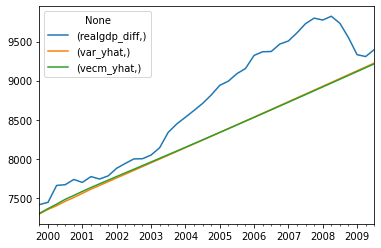

In [239]:
# Generate predictions for both models:

lag_order = var_model['params']['p']
forecast_input = train.values[-lag_order:]
var_model_yhat = pd.DataFrame(var_model['model_obj'].forecast(y=forecast_input, steps=len(test)),columns=['realgdp', 'realdpi', 'cpi'])
var_model_yhat.index=test.index

var_model_yhat
vecm_model_yhat = pd.DataFrame(vecm_model.predict(steps=len(test)),columns=['realgdp', 'realdpi', 'cpi'])
vecm_model_yhat.index=test.index

# Undifference
var_model_gdp = var_model_yhat['realgdp'].cumsum()
vecm_model_gdp = vecm_model_yhat['realgdp'].cumsum()
results = test['realgdp_diff'].cumsum().dropna()

# Build results table
results['var_yhat'] = var_model_gdp
results['vecm_yhat'] = vecm_model_gdp
mean, std = df['realgdp'].mean(), df['realgdp'].std()
print(mean, std)

results = mean + (results * std)
results

results.plot()

var_rmse = (mean_squared_error(results['realgdp_diff'], results['var_yhat']))**0.5
vecm_rmse = (mean_squared_error(results['realgdp_diff'], results['vecm_yhat']))**0.5

print('VAR RMSE:  %5f' % var_rmse)
print('VECM RMSE: %5f' % vecm_rmse)
    

From the results we can see that the predictions are virtually identical and even when comparing RMSE the difference between the two models' performance is very minor. Niether performed particularly well. Choosing one model instead of another in this instance is therefore a question of which assumptions are more likley to hold in "the real world". Personally, I would feel more comfortable using the VECM model as even though the performance is the same (technically, slightly worse), the assumptions allow us to operate at the 95% confidence level, as opposed to 90% for certain variables in the VAR. Additionally, I think the model will be more robust as I deem it more likely that the variables are a linear combination of eachother than that all variables are stationary after differencing. 